# Regression Using StatsModels

In this notebook, we will explore how to **run a linear regression** using the `statsmodels` library in Python to estimate the **beta** and **alpha** of a stock — in this case, **Facebook (FB)** — relative to a market benchmark, **SPY (S&P 500 ETF)**.

---

##### Objective

Our goal is to model the relationship between the returns of Facebook and the returns of the market index. This helps us understand how sensitive Facebook’s returns are to movements in the overall market. The regression model takes the following form:

$$
FB_t = \alpha + \beta \times SPY_t + \varepsilon_t
$$

Where:

| Symbol | Description |
|---------|--------------|
| $FB_t$ | Return of Facebook at time *t* |
| $SPY_t$ | Return of the S&P 500 ETF (market) at time *t* |
| $\alpha$ | The **intercept**, representing the stock’s return independent of market movements (often interpreted as "stock-specific performance" or "excess return") |
| $\beta$ | The **slope coefficient**, representing how sensitive FB’s returns are to movements in the market (systematic risk) |
| $\varepsilon_t$ | The **error term**, capturing idiosyncratic (non-market) effects |

---

##### Interpretation of Parameters

- **Beta (β)** measures **systematic risk**:
  - $\beta > 1$: FB moves **more** than the market (high volatility, higher risk).
  - $\beta < 1$: FB moves **less** than the market (defensive behavior).
  - $\beta = 1$: FB moves roughly **in sync** with the market.

- **Alpha (α)** measures **excess return** not explained by the market:
  - $\alpha > 0$: FB has **outperformed** what the market model predicts.
  - $\alpha < 0$: FB has **underperformed** relative to its market exposure.

---

##### Structure of the notebook:

1. **Import and preprocess data**
   - Download historical price data for FB and SPY (e.g., via `yfinance`).
   - Compute daily or monthly returns.

2. **Run a linear regression**
   - Use `statsmodels.api.OLS()` to regress FB returns on SPY returns.

3. **Analyze results**
   - Extract **alpha**, **beta**, and **R²**.
   - Interpret what the coefficients imply about Facebook’s market risk and performance.

4. **Visualize the relationship**
   - Plot the regression line.
   - Highlight deviations (residuals) and overall fit.

---

##### Expected Outcome

By the end of this notebook, you will be able to:

- Estimate the **CAPM-style regression** parameters (α and β).
- Understand how to use `statsmodels` for financial econometrics.
- Interpret the regression output to assess **market sensitivity** and **stock-specific returns**.

---

**Model Summary:**

$$
FB_t \sim \alpha + \beta \times SPY_t + e_t
$$

Or equivalently, in plain English:

> The return of Facebook at time *t* depends linearly on the return of the market (SPY) plus some residual noise.

---


First, we begin by importing our libraries

In [1]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import yfinance as yf 
import matplotlib.pyplot as plt

# pip install yfinance
# https://pypi.org/project/yfinance/

Next up, we will download the price data for SPY and META starting from 2016 onwards

In [2]:
# download price data
univ = ['SPY','META']
px = yf.download(univ, start="2016-01-01")['Close']

/var/folders/5v/9xrz7nmd29s2z029pvbqs8r00000gn/T/ipykernel_27372/2097513871.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  px = yf.download(univ, start="2016-01-01")['Close']
[*********************100%***********************]  2 of 2 completed


In [3]:
# Derive the percentage returns across time
ret = px / px.shift() - 1 # This is equivalent to px.pct_change()
ret.head()

Ticker,META,SPY
Date,,
2016-01-04,NaN,NaN
2016-01-05,0.004989,0.001691
2016-01-06,0.002336,-0.012614
2016-01-07,-0.049043,-0.023992
2016-01-08,-0.006025,-0.010977


Now, recall from the above that we want to model the return of META as a function of SPY The regression model takes the following form:

$$
FB_t = \alpha + \beta \times SPY_t + \varepsilon_t
$$


In [4]:
# set X and Y. Have to add constant
X = ret[['SPY']] # Our independent variable
X = sm.add_constant(X)  # Adds a constant term to the predictor
Y = ret['META'] # Our dependent variable

In [5]:
# observe x,y
print (X.head()) # A pandas dataframe containing the returns of SPY with a constant term
print (Y.head()) # A pandas series containin the returns of META

            const       SPY
Date                       
2016-01-04    1.0       NaN
2016-01-05    1.0  0.001691
2016-01-06    1.0 -0.012614
2016-01-07    1.0 -0.023992
2016-01-08    1.0 -0.010977
Date
2016-01-04         NaN
2016-01-05    0.004989
2016-01-06    0.002336
2016-01-07   -0.049043
2016-01-08   -0.006025
Name: META, dtype: float64


Before we run our OLS regression, it is important that we drop any NaN terms in our dataframes, as their presence would result in errors being thrown.

In [6]:
# We cannot run OLS before dropping NaNs or missing data
try:
  results = sm.OLS(Y, X).fit()
except Exception as e:
  print("Error:", e)

Error: exog contains inf or nans


Drop the NaNs and run our OLS regression. In addition, we will call summary() to print the summary output of our model

In [7]:
# Drop missing data and run our OLS regression
X = X.dropna()
Y = Y.dropna()
results = sm.OLS(Y, X).fit()
results.summary() # Check the summary of our regression results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   META   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     1528.
Date:                Tue, 20 Jan 2026   Prob (F-statistic):          1.02e-261
Time:                        23:55:31   Log-Likelihood:                 6409.2
No. Observations:                2525   AIC:                        -1.281e+04
Df Residuals:                    2523   BIC:                        -1.280e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.521      0.603      -0.001       0.001
SPY            1.3141      0.034     39.088      0.000       1.248       1.380
==============================================================================
Omnibus:                      857.162   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           137475.273
Skew:                          -0.443   Prob(JB):                         0.00
Kurtosis:                      39.137   Cond. No.                         88.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now that we have our OLS Regression Model, the next step to take is to retrieve our parameters

In [8]:
# get params
"""
const is alpha
SPY is beta
"""
results.params

const    0.000199
SPY      1.314113
dtype: float64

We can also print the residual values

In [9]:
results.resid

Date
2016-01-05    0.002568
2016-01-06    0.018714
2016-01-07   -0.017714
2016-01-08    0.008201
2016-01-11    0.000350
                ...   
2026-01-13   -0.014519
2026-01-14   -0.018411
2026-01-15    0.004801
2026-01-16    0.000017
2026-01-20   -0.002722
Length: 2525, dtype: float64

We can also print the **t-values** of our parameters to assess their **statistical significance**. The **t-value** measures how many standard deviations the estimated coefficient is away from zero. In other words, it helps us test whether the parameter (such as **alpha** or **beta**) is **significantly different from zero**. Mathematically, the t-statistic is defined as:

$$
t = \frac{\hat{\beta} - 0}{SE(\hat{\beta})}
$$

- A **high absolute t-value** (e.g., |t| > 2) generally indicates that the coefficient is **statistically significant** at the 5% level.
- A **low t-value** (close to 0) suggests that the variable does **not have a statistically significant impact** on the dependent variable.

In our regression of **Facebook (FB)** returns against **SPY** returns:

- A significant **β (beta)** means FB’s returns move systematically with the market.
- A significant **α (alpha)** means FB consistently outperforms (or underperforms) the market, independent of market movements.


In [10]:
# get tvalues
results.tvalues

const     0.520844
SPY      39.088111
dtype: float64

With our parameters from our OLS regression, we can reconstruct FB

- FB<sub>t</sub> ~ $\beta$ * SPY<sub>t</sub> + $\alpha$ + e<sub>t</sub>

In [11]:
FB = results.params['SPY']*X['SPY'] + results.params['const'] + results.resid

Now that we have our estimated returns from FB by constructing the model above, we can calculate the difference between the actual and expected returns

In [12]:
# basically identical
(FB-Y).abs().sum()

1.7859520286267472e-16

The small value of all differences added up shows that our OLS regression model mirrors the actual returns of FB closely. Moving on, with reference to the OLS Regression expression again:

$$
FB_t = \alpha + \beta \times SPY_t + \varepsilon_t
$$

We want to store the values for 3 key terms in our expression:

- $\beta$: Our beta term which explains how correlated our asset is to the market SPY
- FB<sub>t</sub>: Our predictor variable
- $\alpha$ + e<sub>t</sub>: The 'tradeable strategy' or the Alpha term and the residual

In [13]:
beta_contr = results.params['SPY']*X['SPY']
prediction = results.params['SPY']*X['SPY'] + results.params['const']
alpha_contr = results.params['const'] + results.resid

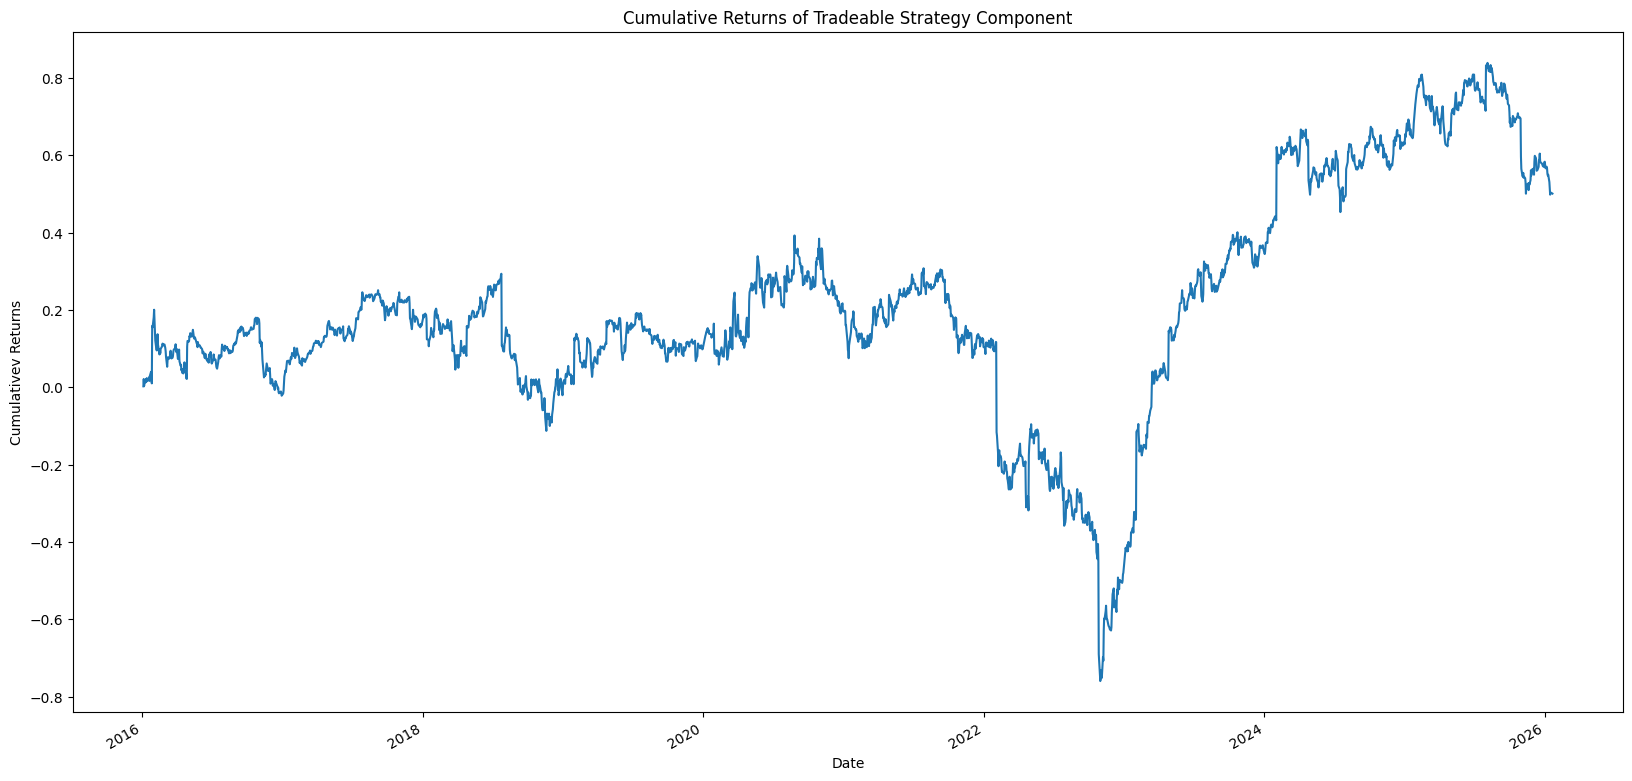

In [14]:
# Let us plot the tradeable strategy component, which is alpha_contr
alpha_contr.cumsum().plot()
plt.title("Cumulative Returns of Tradeable Strategy Component")
plt.xlabel("Date")
plt.ylabel("Cumulativev Returns") 
plt.gcf().set_size_inches(20, 10) # Increase the size of the plot for better visibility
plt.show()


The plot above shows our tradeable strategy or Alpha. This also happens to be the performance of META once it has been de-correlated from SPY. To prove this, we can output the correlation of alpha_contr and SPY

In [15]:
# correl is zero to spy
alpha_contr.corr(X['SPY'])

1.1271194302846789e-16

Our correlation is very close to 0, which supports the idea that our tradeable strategy or Alpha is uncorrelated with the broader market. Next up, we will show 


1. **Mean (Average) Return** of the **de-correlated META (Facebook)** component  
   - This represents the **expected excess return** independent of market risk.

2. **Information Ratio (IR)**  
   - Measures **risk-adjusted performance** relative to the market-neutral benchmark.  
   - Defined as:

     $$
     IR = \frac{\text{Mean of (Active Returns)}}{\text{Standard Deviation of (Active Returns)}}
     $$

     A higher IR indicates more consistent outperformance per unit of risk.

3. **Alpha t-Statistic**  
   - Tests whether the estimated **Alpha (intercept)** from our regression is **statistically different from zero**.  
   - A large absolute t-value (typically |t| > 2) suggests that the alpha is **significant**, implying genuine skill rather than random noise.


In [16]:
# Our 3 key metrics
print("Alpha:", alpha_contr.mean()) # <--- This is the average return of the strategy
print("Information Ratio:", alpha_contr.mean()/alpha_contr.std()*np.sqrt(252)) # <--- This is the information ratio of the strategy
print("Alpha t-stat:", results.tvalues['const']) # <--- This is the t-stat of alpha

Alpha: 0.00019850684393155828
Information Ratio: 0.16481728218468938
Alpha t-stat: 0.5208443577522708


##### Interpretation of Results

| Metric | Value | Interpretation |
|:--------|:-------|:---------------|
| **Alpha (Mean Return)** | 0.000198| This corresponds to an average **daily excess return of about 0.0198%**, or roughly **5.0% annualized** (assuming 252 trading days). This positive alpha suggests the strategy generates slight excess returns on average. |
| **Information Ratio (IR)** | 0.164 | Indicates that for each unit of risk, the strategy delivers 0.164 units of excess return. This is considered **low** — typically, IR > 0.5 is moderate, and IR > 1.0 is strong. |
| **Alpha t-statistic** | 0.521 | The t-stat is **well below 2**, meaning the alpha is **not statistically significant**. In other words, we cannot confidently reject the hypothesis that the strategy’s true alpha is zero. |

---

##### Summary

While the **alpha is positive**, both the **Information Ratio** and **t-statistic** suggest that this excess return is **not statistically distinguishable from random noise**. However, since the **correlation with the market is near zero**, this strategy may still hold **diversification value** when combined with other strategies — especially those with higher market exposure.

---

**Key takeaway:**  
> The strategy appears market-neutral and slightly profitable, but not yet statistically significant. Further refinement or longer data periods may be needed to confirm persistent alpha.
